In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import serial
import time
import os
import json


In [2]:


# prerequest
# Evm use out of box demo
# i18xwr flash out of demo
# S1 switch to 001
# 1. config file
# configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/tx3_rx4_bestRange_beamforming_3region.cfg'
configFileName = r'E:\labotory\mmwave\project\OpenRadar\config\profile_3d_4gBand_close.cfg'
# 2. datacard_config move to mmWave studio folder (postproc)
datacard_config = r'E:\labotory\mmwave\project\OpenRadar\config\datacard_config.json'
# 3. postproc path under mmwave studio folder
postproc_path = "C:/ti/mmwave_studio_02_01_01_00/mmWaveStudio/PostProc"
# 4. CLI port , Dataport COMXX confirm
CLIport = {}
Dataport = {}
real_time = False

portcli="COM23"
portdata="COM22"

In [3]:
# Function to configure the serial ports and send the data from
# the configuration file to the radar
def serialConfig(configFileName):
    global CLIport
    global Dataport
    # Windows
    CLIport = serial.Serial(portcli, 115200)
    Dataport = serial.Serial(portdata, 921600)

    # Read the configuration file and send it to the board
    config = [line.rstrip('\r\n') for line in open(configFileName)]
    for i in config:
        CLIport.write((i + '\n').encode())
        print(i)
        time.sleep(0.001)
    return CLIport, Dataport
def send_stop():
    global CLIport
    global Dataport
    # Windows
    CLIport = serial.Serial(portcli, 115200)
    Dataport = serial.Serial(portdata, 921600)

    CLIport.write(('sensorStop' + '\n').encode())
    print("Sensor Stopped!")

    CLIport.close()
    Dataport.close()

def update_data_config(jsonfile, file_prefix, file_basepath):
    '''
        Function: 更新文件存储路径
    '''
    with open(jsonfile, 'r+') as f:
        data = json.load(f)
        data['DCA1000Config']['captureConfig']['fileBasePath'] = file_basepath
        data['DCA1000Config']['captureConfig']['filePrefix'] = file_prefix

        f.seek(0)  # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()  # remove remaining part

    time.sleep(0.05)

# Function to
def send_cli():
    '''
        Function: 通过调用exe命令来开启数据捕获
    '''
    json_file_name = "datacard_config.json"
    cwd = os.getcwd()
    os.chdir(postproc_path)
    # os.system(f"DCA1000EVM_CLI_Control.exe reset_fpga {json_file_name}")
    os.system(f"DCA1000EVM_CLI_Control.exe fpga {json_file_name}")
    os.system(f"DCA1000EVM_CLI_Control.exe record {json_file_name}")
    os.system(f"DCA1000EVM_CLI_Control.exe start_record {json_file_name}")
    CLIport, Dataport = serialConfig(configFileName)
    # real time, terminate manually
    if real_time:
        print("real-time data collecting, press Esc to exit: ")
        while True:
            try:
                if keyboard.is_pressed('Esc'):
                    print("you pressed Esc, quit data collection..")
                    os.system(f"DCA1000EVM_CLI_Control.exe stop_record {json_file_name}")
                    os.chdir(cwd)
                    time.sleep(1)
                    send_stop()
                    break
            except:
                break
    # os.system(f"DCA1000EVM_CLI_Control.exe stop_record {json_file_name}")
    # os.chdir(cwd)
    return CLIport, Dataport

In [4]:
if __name__ == "__main__":
    start_index = 0
    end_index = 1
    file_name = "Running_{}"
    file_basepath = r"E:\labotory\mmwave\project\OpenRadar\SavedData"

    # interval time >> capture time e.g. ct=5 , interval=8
    interval_time = 10

    # send_stop()
    for i in range(start_index, end_index):

        # preparing data config json file
        file_prefix = file_name.format(i)
        update_data_config(datacard_config, file_prefix, file_basepath)

        # preparing data capture
        # time_start = time.time()
        CLIport, Dataport = send_cli()

        time.sleep(interval_time)

        # close data port
        CLIport.write(('sensorStop\n').encode())
        print("Sensor stops")
        CLIport.close()
        Dataport.close()

% Carrier frequency     GHz                           77
% Ramp Slope    MHz/us                                160
% Num ADC Samples                                     256
% ADC Sampling Rate Msps                              10.8
% ADC Collection Time   us                            23.7
% IDLE TIME  us                                       7.15
% Extra ramp time (ADC start time) us                 1
% Chirp time (end time - start time)    us            24
% Chirp duration (end time) us                        25
% Sweep BW (useful:Chirp time*Ramp Slope) MHz         3840
% Total BW  (Chirp duration*Ramp Slope)MHz            4000
% Max beat freq (80% of ADC sampling rate)  MHz       8.64
% Max distance (80% of fs*c/2s)    m                  8.10
% Range resolution(useful c/2BW)  cm                  3.906
% Range resolution (meter per 1D-FFT bin)   m/bin     0.039
%                                                     
% Inter-chirp duration  us                            7.15
% Number o

In [5]:
#import sys
#sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import mmwave as mm
import mmwave.dsp as dsp
from mmwave.dataloader import DCA1000
from mmwave.tracking import EKF
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [30]:
# Radar specific parameters
NUM_RX = 4
NUM_TX=3
VIRT_ANT = 12    #这个参数含义

NUM_CHIRPS = 32    # frameCfg: number of loops
NUM_ADC_SAMPLES = 256

NUM_FRAMES = 300          # frameCfg: number of frames

# Data sampling configuration
c = 3e8 # Speed of light (m/s)
sample_rate = 10800 # Rate at which the radar samples from ADC (ksps - kilosamples per second)
freq_slope = 160 # Frequency slope of the chirp (MHz/us)

              
# doppler   查看 profileCfg 对应的参数命令
Band_Width=band_width
Start_Freq_Const=77
Idle_Time_Const=7.15
Ramp_End_Time=25
Num_Loops_Per_Frame=32
# DSP processing parameters
SKIP_SIZE = 4
ANGLE_RES = 1
ANGLE_RANGE = 90
ANGLE_BINS = (ANGLE_RANGE * 2) // ANGLE_RES + 1
BINS_PROCESSED = 256          # 这个参数作用是什么

In [8]:


filename=r'E:\labotory\mmwave\project\OpenRadar\SavedData\Running_0_Raw_0.bin'
adc_data = np.fromfile(filename, dtype=np.uint16)
print(adc_data.shape,type(adc_data),adc_data[0])
adc_data = adc_data.reshape(NUM_FRAMES, -1)
print(type(adc_data),adc_data.shape)    #<class 'numpy.ndarray'> (300, 262144)


(58982400,) <class 'numpy.ndarray'> 64426
<class 'numpy.ndarray'> (300, 196608)


In [9]:
all_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=NUM_CHIRPS*NUM_TX, num_rx=NUM_RX, num_samples=NUM_ADC_SAMPLES)
print(type(all_data),all_data.shape)  

<class 'numpy.ndarray'> (300, 96, 4, 256)


In [18]:

# Start DSP processing
range_azimuth = np.zeros((ANGLE_BINS, BINS_PROCESSED))
num_vec, steering_vec = dsp.gen_steering_vec(ANGLE_RANGE, ANGLE_RES, VIRT_ANT)
tracker = EKF()
singleframe=all_data[10]

In [19]:
radar_cube = dsp.range_processing(singleframe)  #（96, 4, 256）  （NUM_CHIRPS*3, num_rx=NUM_RX, num_samples）  对 num_samples 进行FFT处理
print(type(radar_cube),radar_cube.shape)
# --- static clutter removal
mean = radar_cube.mean(0)                 
radar_cube = radar_cube - mean     

<class 'numpy.ndarray'> (96, 4, 256)


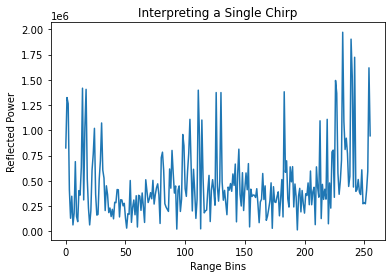

In [20]:
#绘制一个接受天线 sample data 对应的range bin
plt.plot(np.abs(radar_cube[0][0])) 
plt.xlabel('Range Bins')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Chirp')
plt.show()

Range Resolution: 0.03952341975585938 [meters]


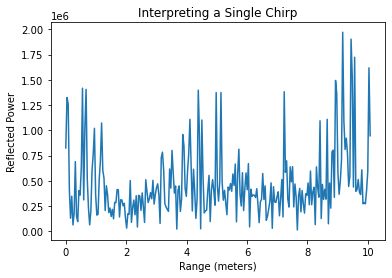

In [21]:


range_res, band_width=dsp.range_resolution(NUM_ADC_SAMPLES,sample_rate,freq_slope)  #单位m
print(f'Range Resolution: {range_res} [meters]')

# Apply the range resolution factor to the range indices
ranges = np.arange(NUM_ADC_SAMPLES) * range_res
powers = np.abs(radar_cube[0][0])       #（NUM_CHIRPS*3, num_rx=NUM_RX, num_samples）

# Now we can plot again with an x-axis that makes sense
plt.plot(ranges, powers)
plt.xlabel('Range (meters)')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Chirp')
plt.show()

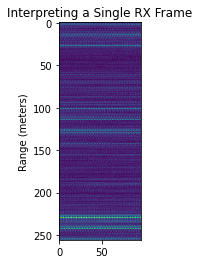

In [50]:
plt.imshow(np.abs(radar_cube[:,1,:]).T)
plt.ylabel('Range (meters)')
plt.title('Interpreting a Single RX Frame')
plt.show()

(96, 256)


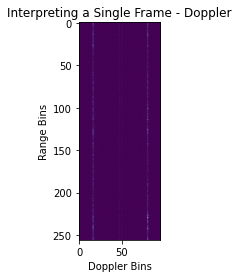

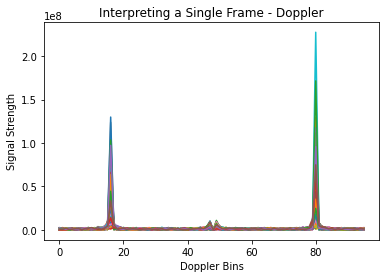

In [27]:
# Take a sequential FFT across the chirps
range_doppler = np.fft.fft(radar_cube[:,1,:], axis=0)
print(range_doppler.shape)
# FFT shift the values (explained later)
range_doppler = np.fft.fftshift(range_doppler, axes=0)

# Visualize the range-doppler plot
# plt.imshow(np.log(np.abs(range_doppler).T))
plt.imshow(np.abs(range_doppler).T)
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Rx Frame - Doppler')
plt.show()

plt.plot(np.abs(range_doppler))
plt.xlabel('Doppler Bins')
plt.ylabel('Signal Strength')
plt.title('Interpreting a Single Rx Frame - Doppler')
plt.show()

D:\work_anaconda_download\envs\pytorch\lib\site-packages\mmwave\dsp\doppler_processing.py:132: RuntimeWarning: divide by zero encountered in log2
  fft2d_log_abs = np.log2(np.abs(fft2d_out))


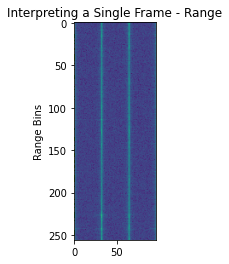

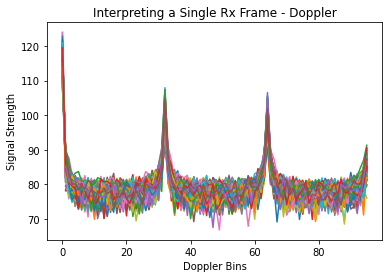

In [48]:
fft2d_log_abs, aoa_input = dsp.doppler_processing(radar_cube=radar_cube,num_tx_antennas=NUM_TX,clutter_removal_enabled=True,interleaved=False,accumulate=True)  #（96, 4, 256）  （NUM_CHIRPS*3, num_rx=NUM_RX, num_samples）  对 num_samples 进行FFT处理
# (numRangeBins, num_doppler_bins) ,(numRangeBins, numVirtualAntennas, num_doppler_bins) 
#print(type(radar_cube),fft2d_log_abs.shape.shape)  
plt.imshow(np.abs(fft2d_log_abs))
plt.ylabel('Range Bins')
plt.xlabel('Doppler Bins')
plt.title('Interpreting a Single Frame - Range')
plt.show()
plt.plot(np.abs(fft2d_log_abs).T)
plt.xlabel('Doppler Bins')
plt.ylabel('Signal Strength')
plt.title('Interpreting a Single Rx Frame - Doppler')
plt.show()

In [38]:

doppler_resolution=dsp.doppler_resolution(band_width=Band_Width, start_freq_const=Start_Freq_Const, ramp_end_time=Ramp_End_Time, idle_time_const=Idle_Time_Const, num_loops_per_frame=Num_Loops_Per_Frame,
                       num_tx_antennas=NUM_TX)
print(f'doppler Resolution: {doppler_resolution} [meters/s]')

doppler Resolution: 0.6155762856144322 [meters/s]


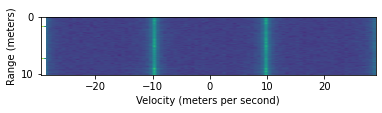

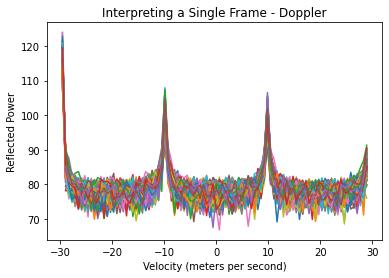

In [44]:
# Apply the velocity resolution factor to the doppler indicies
velocities = np.arange(NUM_CHIRPS*3) - (NUM_CHIRPS*3 // 2)
velocities = velocities * doppler_resolution

powers = np.abs(fft2d_log_abs).T


# Plot with units
plt.imshow(powers.T, extent=[velocities.min(), velocities.max(), ranges.max(), ranges.min()])
plt.xlabel('Velocity (meters per second)')
plt.ylabel('Range (meters)')
plt.show()
#print("velocities shape:",velocities, " powers shape:",powers)
plt.plot(velocities, powers)
plt.xlabel('Velocity (meters per second)')
plt.ylabel('Reflected Power')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

(256, 4, 96)
(96, 4, 256)


D:\work_anaconda_download\envs\pytorch\lib\site-packages\mmwave\dsp\doppler_processing.py:132: RuntimeWarning: divide by zero encountered in log2
  fft2d_log_abs = np.log2(np.abs(fft2d_out))


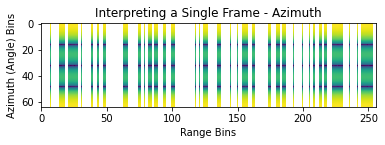

In [68]:
fft2d_log_abs, aoa_input = dsp.doppler_processing(radar_cube=radar_cube,num_tx_antennas=NUM_TX,clutter_removal_enabled=True,interleaved=False,accumulate=False)  #（96, 4, 256）  （NUM_CHIRPS*3, num_rx=NUM_RX, num_samples）  对 num_samples 进行FFT处理
print(fft2d_log_abs.shape) #(256, 4, 96) (numRangeBins,Rx, num_doppler_bins)
range_doppler = np.transpose(fft2d_log_abs, axes=(2, 1, 0))   #(num_doppler_bins,Rx,numRangeBins)
#range_doppler=np.abs(fft2d_log_abs)
print(range_doppler.shape)
num_angle_bins = 64
padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0))
range_azimuth = np.pad(range_doppler, padding, mode='constant')
range_azimuth = np.fft.fft(range_azimuth, axis=1)
range_azimuth = range_azimuth
# Visualize Results
plt.imshow(np.log(np.abs(range_azimuth).sum(0)))
plt.ylabel('Azimuth (Angle) Bins')
plt.xlabel('Range Bins')
plt.title('Interpreting a Single Frame - Azimuth')
plt.show()

In [59]:
mean = radar_cube.mean(0)                 
radar_cube = radar_cube - mean    
angle=dsp.azimuth_processing(radar_cube, det_obj_2d=[1,3], window_type_2d=None)

TypeError: azimuth_processing() missing 1 required positional argument: 'config'